In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.24G/3.24G [01:24<00:00, 42.5MB/s]
100% 3.24G/3.24G [01:24<00:00, 41.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/a-large-scale-fish-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
'''Data Handling & Linear Algebra'''
import numpy as np
import pandas as pd
import os

'''Visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns

'''Manipulating Data and Model Building'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

'''Implementation of Transfer Learning'''
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet101


'''Image generation and preprocessing'''
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

'''Result and Performance Analysis'''
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

'''Ignoring Warnings'''
import warnings
warnings.filterwarnings("ignore")

In [ ]:
DIR = '/content/Fish_Dataset/Fish_Dataset' #Creating a master directory
classes = [i for i in os.listdir(DIR) if '.' not in i]                     #Creating classes out of the required folders
classes

['Sea Bass',
 'Shrimp',
 'Black Sea Sprat',
 'Trout',
 'Red Sea Bream',
 'Striped Red Mullet',
 'Hourse Mackerel',
 'Gilt-Head Bream',
 'Red Mullet']

In [ ]:
'''Since the GT images are of no use to us for the analysis, we will be separating them out of our directory'''

# Create a dataframe with a column which consists of all the filepaths (without GT) and its respective label as the other column

label = []
path = []

for dirname, _,filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dirname.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dirname)[-1])         # Append the directory name to label
                path.append(os.path.join(dirname,filename))     # Append all the png files to path of that directory

# Ready to create the df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [ ]:
df.head()

,path,label
0,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
1,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
2,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
3,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
4,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass


In [ ]:
df.path[0]

'/content/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00036.png'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [ ]:
df['label'].value_counts()

label
Sea Bass              1000
Shrimp                1000
Black Sea Sprat       1000
Trout                 1000
Red Sea Bream         1000
Striped Red Mullet    1000
Hourse Mackerel       1000
Gilt-Head Bream       1000
Red Mullet            1000
Name: count, dtype: int64

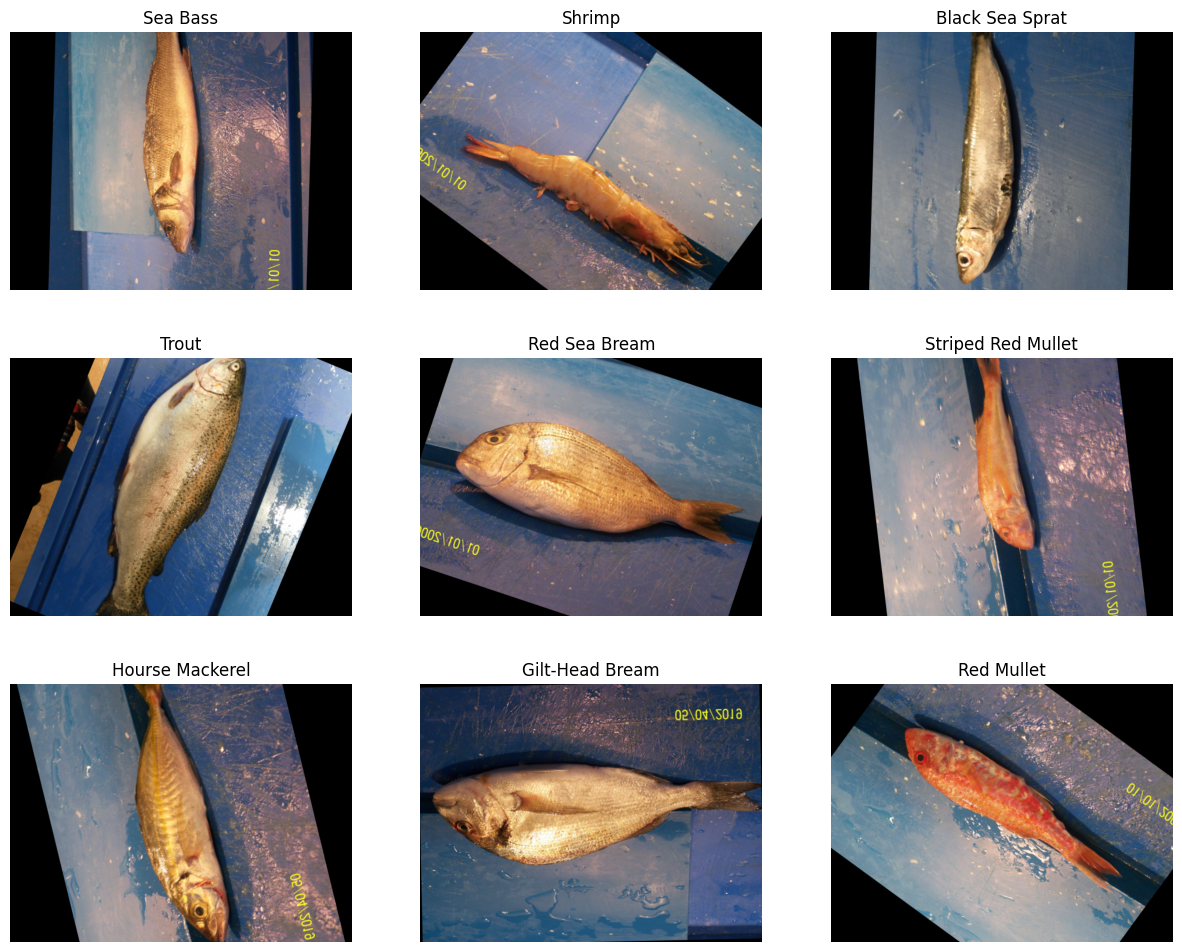

In [ ]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

Train-Test Data split

In [ ]:
#Creating the test train split with shuffle
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

Image Generation and Preprocessing

In [ ]:
#Using Keras Image Data Generator to preprocess our images with the model we wish to use
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )


Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [ ]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

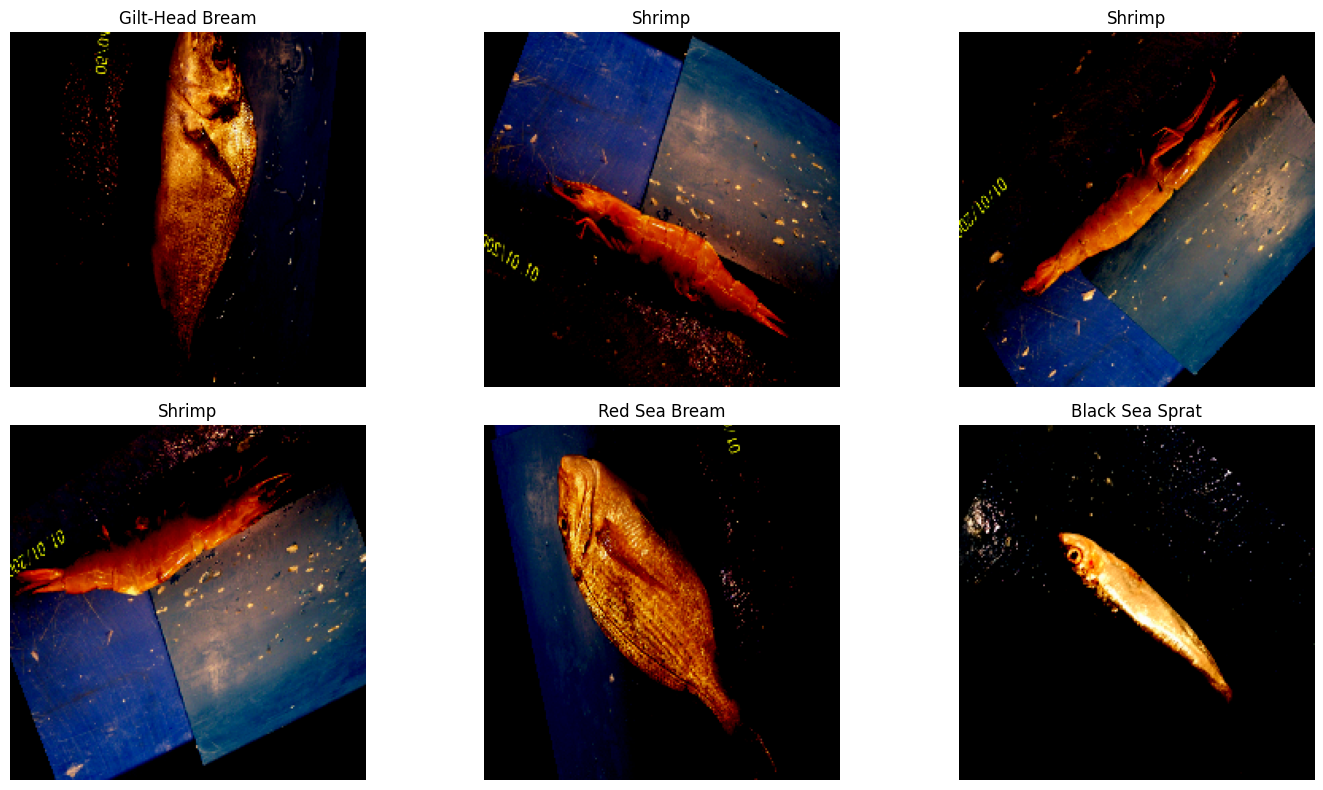

In [ ]:
# Plotting images after pre-processing
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()

class_indices = test_images.class_indices
class_labels = {v: k for k, v in class_indices.items()}

j = 0
for _ in range(6):
    img, label = test_images.next()
    ax[j].imshow(img[0])
    label_index = np.argmax(label[0])  # Convert one-hot encoding to label index
    label_name = class_labels[label_index]  # Get class name from index
    ax[j].set_title(label_name)
    ax[j].axis('off')
    j += 1

plt.tight_layout()
plt.show()

In [ ]:
# Importing our pretrained model: ResNet
pretrained_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

94668760/94668760 [==============================] - 3s 0us/step


In [ ]:
# Creating our model inputs
inputs = pretrained_model.input

# Adding dense layers on top of the pretrained model
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)  # Assuming there are 9 classes

# Creating the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Model summary
model.summary()

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
# Incorrect prediction
pred_df[pred_df['label']!=pred_df['pred']]

In [ ]:
pred_df.path[835]

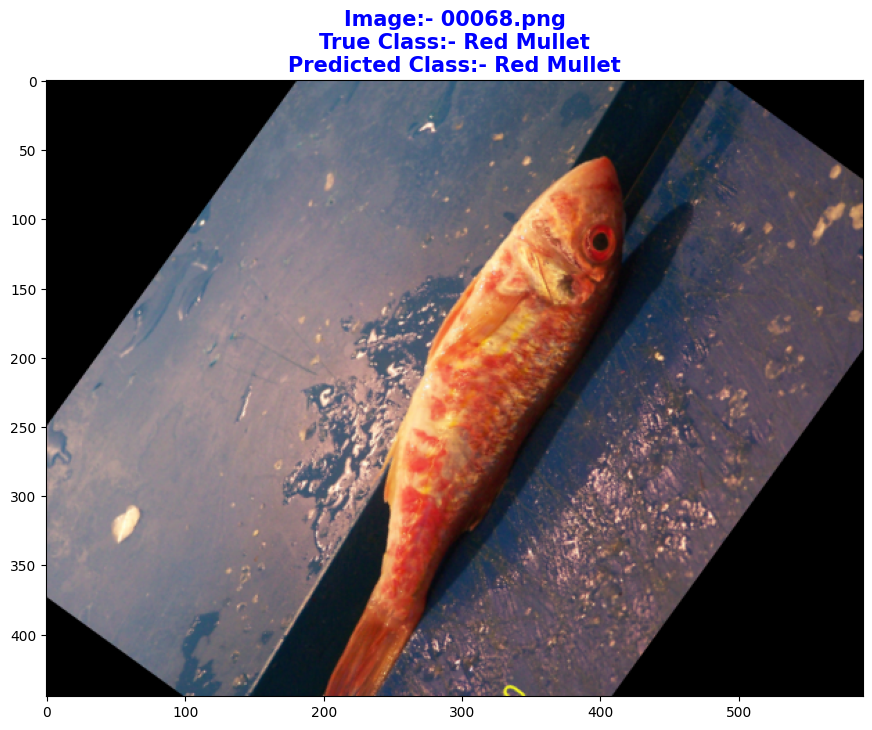

In [ ]:
#True label of incorrect prediction
plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[8008]))
title1 = pred_df.path[8008].split('/')[-2]
title2 = pred_df.path[8008].split('/')[-1]
title3 = pred_df.pred[8008]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'b', weight = 'bold', fontsize = 15)
plt.show()

In [ ]:
# Calculate the accuracy score
accuracy = accuracy_score(pred_df['label'], pred_df['pred'])
print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.9694444444444444


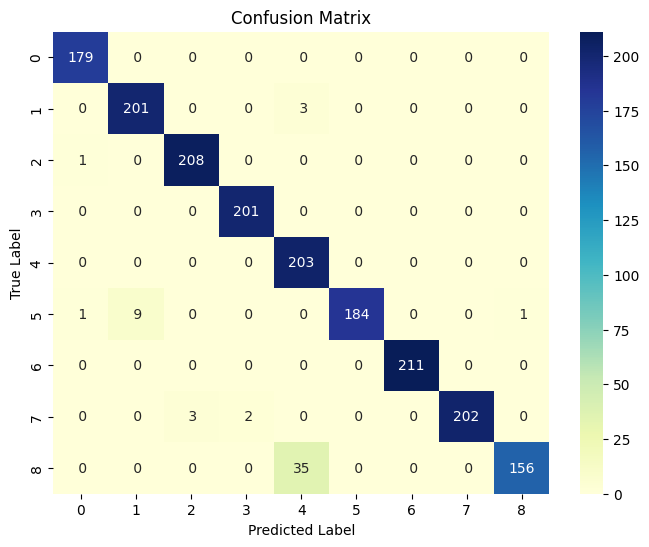

In [ ]:
# Create a confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(pred_df['label'], pred_df['pred']), annot=True, fmt='2d', cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Generate the classification report
from sklearn.metrics import classification_report
report = classification_report(pred_df['label'], pred_df['pred'])
print(report)

                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      1.00      0.99       179
   Gilt-Head Bream       0.96      0.99      0.97       204
   Hourse Mackerel       0.99      1.00      0.99       209
        Red Mullet       0.99      1.00      1.00       201
     Red Sea Bream       0.84      1.00      0.91       203
          Sea Bass       1.00      0.94      0.97       195
            Shrimp       1.00      1.00      1.00       211
Striped Red Mullet       1.00      0.98      0.99       207
             Trout       0.99      0.82      0.90       191

          accuracy                           0.97      1800
         macro avg       0.97      0.97      0.97      1800
      weighted avg       0.97      0.97      0.97      1800

